In [1]:
import sys
sys.path.append('..')
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio

import phonemizer

import torch
import copy

In [2]:
os.chdir('/home/ubuntu/loop')

In [3]:
os.getcwd()

'/home/ubuntu/loop'

In [4]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [5]:
def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [6]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio

## Generate Code

In [7]:
output_dir = './'
output_file = 'test.wav'

npz = ''
text = 'Your tickets for the social issues'
text = 'see that girl watch that scene'
#text = 'twice is nice'
spkr_id = 8
checkpoint = 'checkpoints/vctk/lastmodel.pth'
#checkpoint = 'models/vctk/bestmodel.pth'
checkpoint = 'checkpoints/vctk-deleteme/lastmodel.pth'
#checkpoint = '/home/ubuntu/original-loop/checkpoints/vctk-original/lastmodel.pth'
gpu = 0

In [104]:
weights = torch.load(checkpoint,
                     map_location=lambda storage, loc: storage)
opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
train_args = opt[0]

In [105]:
#train_dataset = NpzFolder(train_args.data + '/numpy_features')
train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
char2code = train_dataset.dict
spkr2code = train_dataset.speakers

norm_path = train_args.data + '/norm_info/norm.dat'
norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
train_args.noise = 0

In [106]:
model = Loop(train_args)
model.load_state_dict(weights)
if gpu >= 0:
    model.cuda()
model.eval()

if spkr_id not in range(len(spkr2code)):
    print('ERROR: Unknown speaker id: %d.' % spkr_id)

txt, feat, spkr, output_fname = None, None, None, None
if npz is not '':
    txt, feat = npy_loader_phonemes(npz)

    txt = Variable(txt.unsqueeze(1), volatile=True)
    feat = Variable(feat.unsqueeze(1), volatile=True)
    spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

    output_file = os.path.basename(npz)[:-4]
elif text is not '':
    txt = text2phone(text, char2code)
    feat = torch.FloatTensor(txt.size(0)*20, 63)
    spkr = torch.LongTensor([spkr_id])

    txt = Variable(txt.unsqueeze(1), volatile=True)
    feat = Variable(feat.unsqueeze(1), volatile=True)
    spkr = Variable(spkr, volatile=True)

    output_file = text.replace(' ', '_')
else:
    print('ERROR: Must supply npz file path or text as source.')
    raise Exception('Need source')
    

In [107]:
if gpu >= 0:
    txt = txt.cuda()
    feat = feat.cuda()
    spkr = spkr.cuda()


out, attn = model([txt, spkr], feat)
out, attn = trim_pred(out, attn)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

generate_merlin_wav(out.data.cpu().numpy(),
                    output_dir,
                    output_file,
                    norm_path)

if npz is not '':
    output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
    generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                        output_dir,
                        output_orig_fname,
                        norm_path)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete see_that_girl_watch_that_scene.wav.


In [108]:
Audio(output_file + '.wav', autoplay=True)

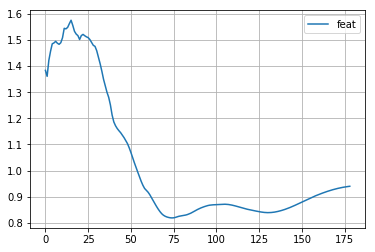

In [102]:
# Visualise LF0
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 61])
plt.grid(True)
plt.legend(['feat', 'out'])

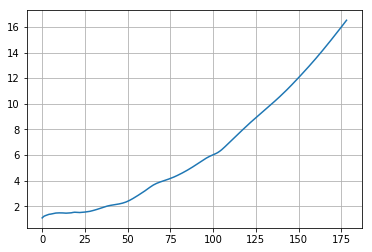

In [77]:
# Modify LF0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 61] += np.square(np.linspace(0,4,hack_feat.shape[0]))
plt.plot(hack_feat[:, 0, 61])
plt.grid(True)

output_file_hack = output_file + '_hack'

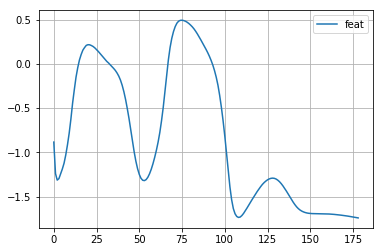

In [78]:
# Visualise VUV
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 60])
plt.grid(True)
plt.legend(['feat', 'out'])

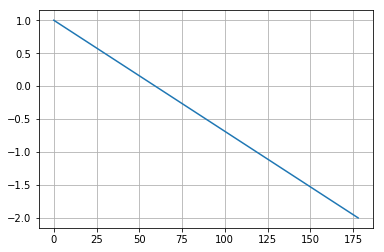

In [79]:
# Modify VUV
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 60] = np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 60])
plt.grid(True)

output_file_hack = output_file + '_hack'

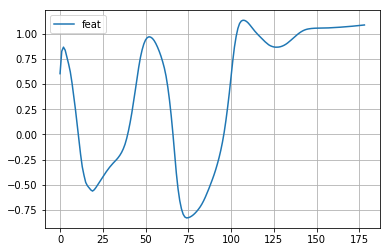

In [80]:
# Visualise BAP
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 62])
plt.grid(True)
plt.legend(['feat', 'out'])

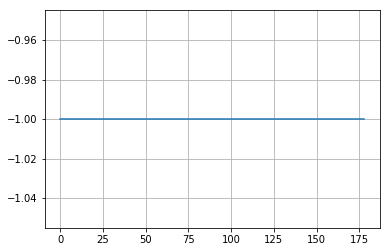

In [81]:
# Modify BAP
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 62] = -1# np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 62])
plt.grid(True)

output_file_hack = output_file + '_hack'

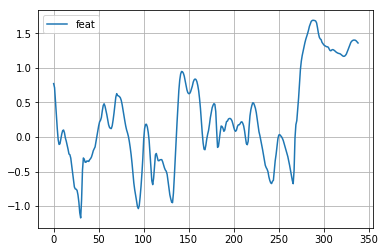

In [277]:
# Visualise MGC0
idx_mgc = 10
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
plt.plot(np_out[:, 0, idx_mgc])
plt.grid(True)
plt.legend(['feat', 'out'])

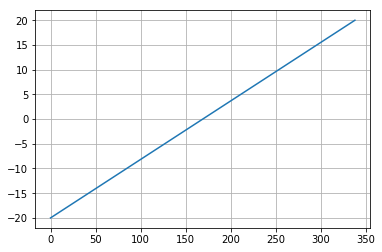

In [278]:
# Modify MGC0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, idx_mgc] = np.linspace(-20,+20,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, idx_mgc])
plt.grid(True)

output_file_hack = output_file + '_hack'

#### Generate .wav file from hacked features

In [82]:
generate_merlin_wav(hack_feat[:, 0, :],
                    output_dir,
                    output_file_hack,
                    norm_path)

Audio(output_file_hack + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete twice_is_nice_hack.wav.


In [280]:
hack_feat.shape

(339, 1, 63)

In [281]:
# TODO
# .wav file visualisation
# spectrogram?
# use pydub?
# look at normalisation of the features?
# can I get MSE out?

## Spectrograms

In [341]:
import spectrogram as sp

# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

In [342]:
### Parameters ###
fft_size = 480# 2048 # window size for the FFT
#step_size = int(fft_size/16) # distance to slide along the window (in time)
step_size = 160 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

# For mels
n_mel_freq_components = 40# 64 # number of mel frequency channels
shorten_factor = 1#10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from

In [343]:
output_file

'see_that_girl_watch_that_scene'

In [344]:
# This is a nice, clean possum sample
mywav = output_file + '.wav'
mywav_hack = output_file_hack + '.wav'

rate, data = wavfile.read(mywav)
data = sp.butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
#data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10] 
print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

rate, data_hack = wavfile.read(mywav_hack)
data_hack = sp.butter_bandpass_filter(data_hack, lowcut, highcut, rate, order=1)

Length in time (s):1.6900625


In [345]:
# Play the audio
IPython.display.Audio(data=data, rate=rate, autoplay=True)

In [346]:
IPython.display.Audio(data=data_hack, rate=rate, autoplay=True)

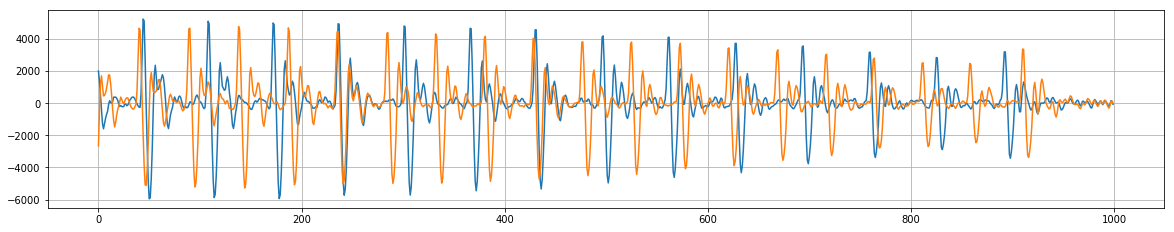

In [347]:
# Plot raw sound data
idx_start = 6000
idx_end = 7000
plt.figure(figsize=[20,8])

plt.subplot(2,1,1)
plt.plot(data[idx_start:idx_end])
#plt.grid()

#plt.subplot(2,1,2)
plt.plot(data_hack[idx_start:idx_end])
plt.grid()

In [348]:
#plt.plot(data_hack - data)

In [349]:
wav_spectrogram = sp.pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

wav_spectrogram_hack = sp.pretty_spectrogram(data_hack.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

Text(0.5,1.05,u'Difference')

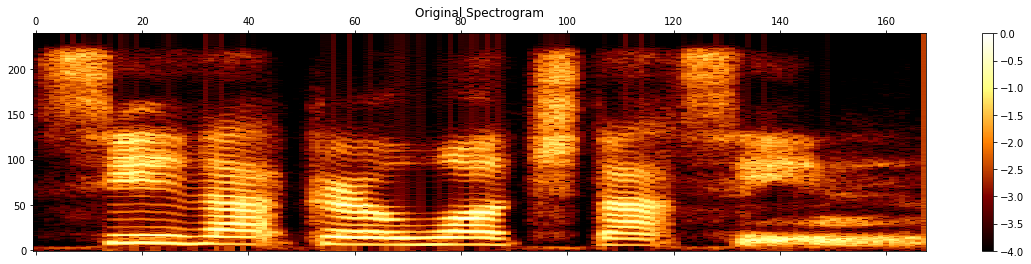

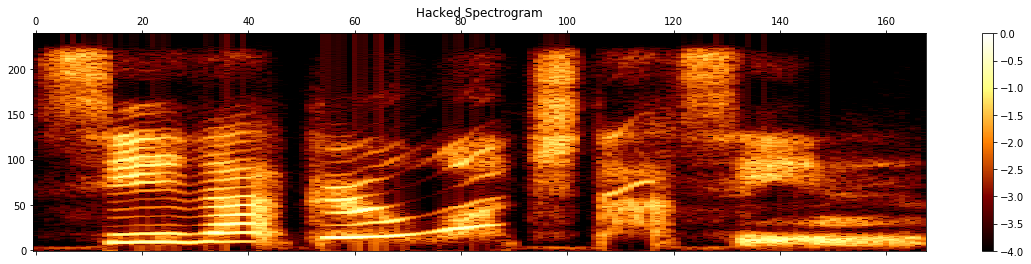

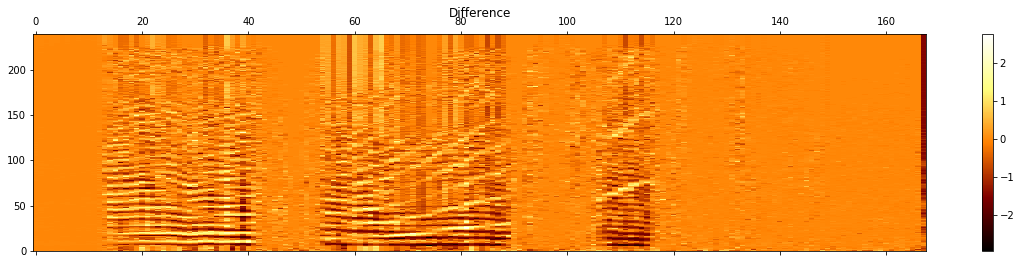

In [350]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack - wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [336]:
print np.mean(np.square(wav_spectrogram))
print np.mean(np.square(wav_spectrogram_hack - wav_spectrogram))

9.36202110683
0.149842307785


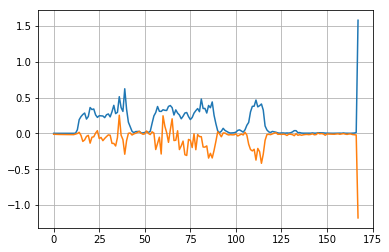

In [338]:
x = wav_spectrogram_hack - wav_spectrogram
plt.plot(np.mean(np.square(x), 1))
plt.grid(True)
plt.plot(np.mean(x, 1))
plt.grid(True)

### Mel Spectrograms

In [294]:
# Generate the mel filters
mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq, samplerate=16000) # may need to change sample rate

Text(0.5,1.05,u'mel Inversion Filter')

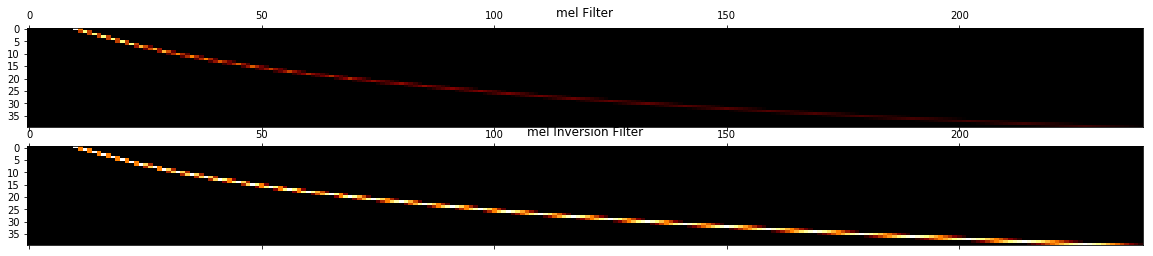

In [295]:
# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

In [296]:
mel_spec = sp.make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
mel_spec_hack = sp.make_mel(wav_spectrogram_hack, mel_filter, shorten_factor = shorten_factor)

Text(0.5,1.05,u'Difference')

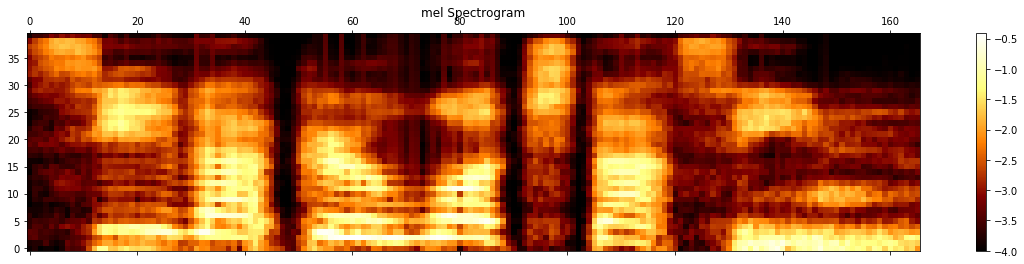

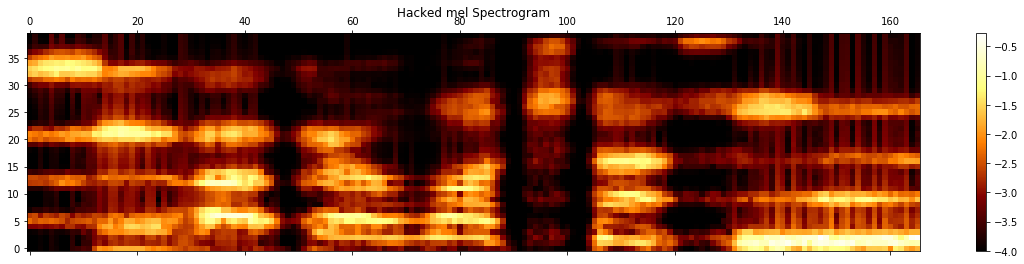

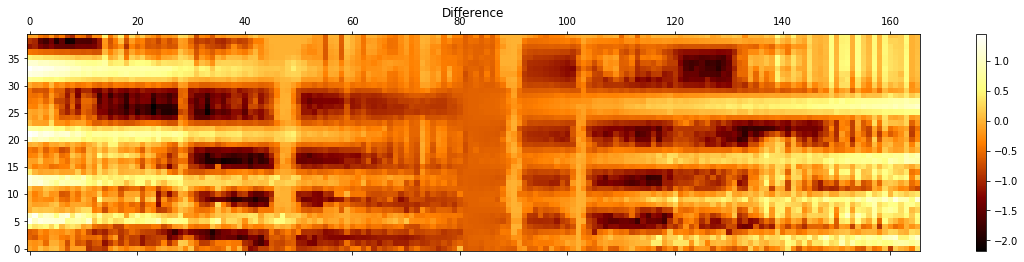

In [297]:
# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('mel Spectrogram')

# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked mel Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack - mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [300]:
print np.mean(np.square(mel_spec))
print np.mean(np.square(mel_spec_hack - mel_spec))

8.1484
0.44263


### Spectrogram Inversion etc.

In [267]:
# Output some stats of our file
print(''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))]))
print(''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))]))
print(''.join(['Original Waveform Size: ',str(np.shape(data))]))
print(''.join(['Length (s): ', str(len(data)/float(rate))]))
print(''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))]))
print(''.join(['New Sampling Rate (ms): ', str(float(np.shape(mel_spec)[1]) / (len(data)/float(rate)))]))

mel Spectrogram Size: (40, 166)
Original Spectrogram Size: (240, 168)
Original Waveform Size: (27041,)
Length (s): 1.6900625
Original Sampling Rate (ms) : 6.25e-05
New Sampling Rate (ms): 98.2212196295


In [268]:
mel_inverted_spectrogram = sp.mel_to_spectrogram(mel_spec, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

Text(0.5,1.05,u'Inverted mel Spectrogram')

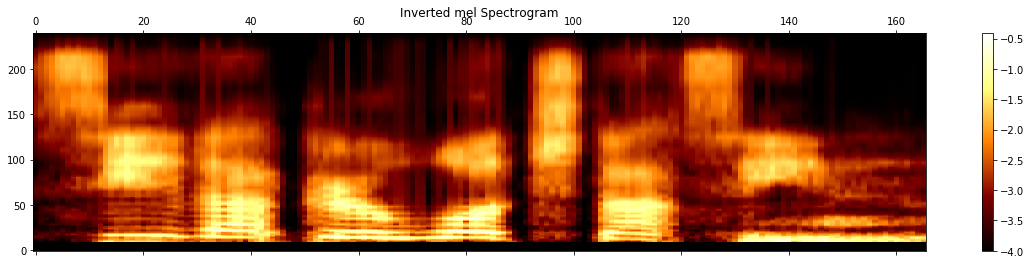

In [269]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.float64(mel_inverted_spectrogram), cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')

In [270]:
inverted_mel_audio = sp.invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

ValueError: operands could not be broadcast together with shapes (166,480) (165,480) 